# How to: assign ChIP-seq peaks to genes

This tutorial demonstrates one way to assign CTCF ChIP-seq peaks to the nearest genes using bioframe.

In [1]:
import matplotlib.pyplot as plt
import numpy as np

import bioframe

In [72]:
base_dir = "/tmp/bioframe_tutorial_data/"
assembly = "hg38"

## Load chromosome sizes


In [74]:
chromsizes = bioframe.fetch_chromsizes(assembly)
chromsizes.tail()

chr21     46709983
chr22     50818468
chrX     156040895
chrY      57227415
chrM         16569
Name: length, dtype: int64

In [78]:
chromosomes = bioframe.make_viewframe(chromsizes)

## Load CTCF ChIP-seq peaks for HFF from ENCODE

This approach makes use of the `narrowPeak` schema for bioframe.read_table . 

In [3]:
ctcf_peaks = bioframe.read_table(
    "https://www.encodeproject.org/files/ENCFF401MQL/@@download/ENCFF401MQL.bed.gz",
    schema="narrowPeak",
)
ctcf_peaks.head()

,chrom,start,end,name,score,strand,fc,-log10p,-log10q,relSummit
0,chr19,48309541,48309911,.,1000,.,5.04924,-1.0,0.00438,185
1,chr4,130563716,130564086,.,993,.,5.05052,-1.0,0.00432,185
2,chr1,200622507,200622877,.,591,.,5.05489,-1.0,0.00400,185
3,chr5,112848447,112848817,.,869,.,5.05841,-1.0,0.00441,185
4,chr1,145960616,145960986,.,575,.,5.05955,-1.0,0.00439,185


In [83]:
# Filter for selected chromosomes:
ctcf_peaks = bioframe.overlap(ctcf_peaks, chromosomes).dropna(subset=["name_"])[
    ctcf_peaks.columns
]

## Get list of genes from UCSC

UCSC genes are stored in .gtf format.

In [4]:
genes_url = (
    "https://hgdownload.soe.ucsc.edu/goldenpath/hg38/bigZips/genes/hg38.ensGene.gtf.gz"
)
genes = bioframe.read_table(genes_url, schema="gtf").query('feature=="CDS"')

genes.head()

## Note this functions to parse the attributes of the genes:
# import bioframe.sandbox.gtf_io
# genes_attr = bioframe.sandbox.gtf_io.parse_gtf_attributes(genes['attributes'])

,chrom,source,feature,start,end,score,strand,frame,attributes
47,chr1,ensGene,CDS,69091,70005,.,+,0,"gene_id ""ENSG00000186092""; transcript_id ""ENST..."
112,chr1,ensGene,CDS,182709,182746,.,+,0,"gene_id ""ENSG00000279928""; transcript_id ""ENST..."
114,chr1,ensGene,CDS,183114,183240,.,+,1,"gene_id ""ENSG00000279928""; transcript_id ""ENST..."
116,chr1,ensGene,CDS,183922,184155,.,+,0,"gene_id ""ENSG00000279928""; transcript_id ""ENST..."
122,chr1,ensGene,CDS,185220,185350,.,-,2,"gene_id ""ENSG00000279457""; transcript_id ""ENST..."


In [84]:
# Filter for selected chromosomes:
genes = bioframe.overlap(genes, chromosomes).dropna(subset=["name_"])[genes.columns]

## Assign each peak to the gene

![Setup](https://raw.githubusercontent.com/open2c/bioframe/main/docs/figs/closest0.png)

![Default closests](https://raw.githubusercontent.com/open2c/bioframe/main/docs/figs/closest3.png)

Here, we want to assign each peak (feature) to a gene (input table).

In [85]:
peaks_closest = bioframe.closest(genes, ctcf_peaks)

(0.0, 1000.0)

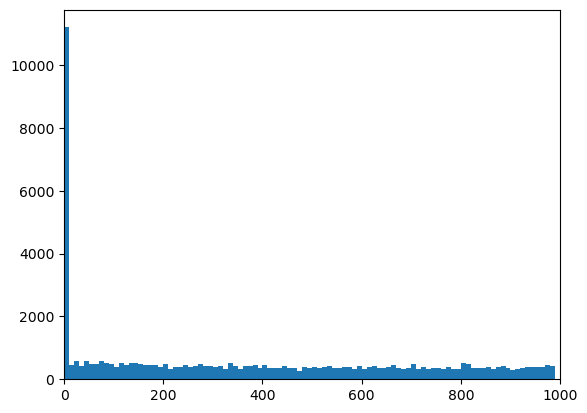

In [87]:
# Plot the distribution of distances from peaks to genes:
plt.hist(peaks_closest["distance"], np.arange(0, 1e3, 10))
plt.xlim([0, 1e3])

## Ignore upstream/downstream peaks from genes (strand-indifferent version)

Sometimes you may want to ignore all the CTCFs upstream from the genes. 

By default, `bioframe.overlap` does not know the orintation of the genes, and thus assumes that the upstream/downstream is defined by the genomic coordinate (upstream is the direction towards the smaller coordinate):

![Closests with ignoring](https://raw.githubusercontent.com/open2c/bioframe/main/docs/figs/closest2.png)


In [88]:
peaks_closest_upstream_nodir = bioframe.closest(
    genes,
    ctcf_peaks,
    ignore_overlaps=False,
    ignore_upstream=False,
    ignore_downstream=True,
    direction_col=None,
)

peaks_closest_downstream_nodir = bioframe.closest(
    genes,
    ctcf_peaks,
    ignore_overlaps=False,
    ignore_upstream=True,
    ignore_downstream=False,
    direction_col=None,
)

Note that distribution did not change much, and upstream and downstream distances are very similar:

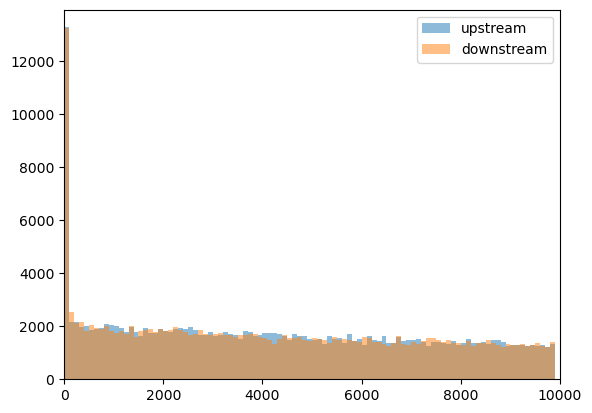

In [92]:
plt.hist(
    peaks_closest_upstream_nodir["distance"],
    np.arange(0, 1e4, 100),
    alpha=0.5,
    label="upstream",
)
plt.hist(
    peaks_closest_downstream_nodir["distance"],
    np.arange(0, 1e4, 100),
    alpha=0.5,
    label="downstream",
)
plt.xlim([0, 1e4])
plt.legend()

## Ignore upstream/downstream peaks from genes (strand-aware version)

More biologically relevant approach will be to **define upstream/downstream by strand of the gene**.
CTCF upstream of transcription start site might play different role than CTCF after transcription end site. 

`bioframe.closest` has the parameter `direction_col` to control for that: 

![Closests with smart ignoring](https://raw.githubusercontent.com/open2c/bioframe/main/docs/figs/closest1.png)


In [90]:
# Note that "strand" here is the column name in genes table:
peaks_closest_upstream_dir = bioframe.closest(
    genes,
    ctcf_peaks,
    ignore_overlaps=False,
    ignore_upstream=False,
    ignore_downstream=True,
    direction_col="strand",
)

peaks_closest_downstream_dir = bioframe.closest(
    genes,
    ctcf_peaks,
    ignore_overlaps=False,
    ignore_upstream=True,
    ignore_downstream=False,
    direction_col="strand",
)

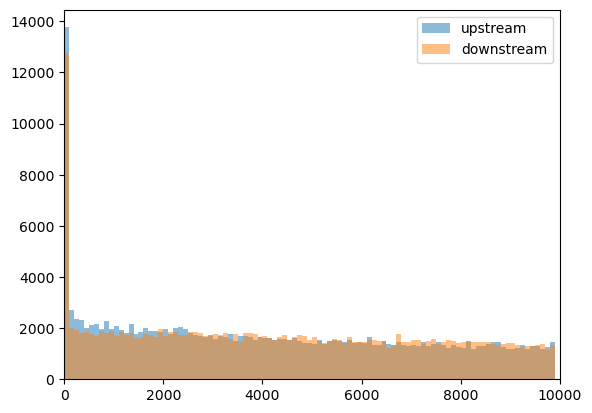

In [96]:
plt.hist(
    peaks_closest_upstream_dir["distance"],
    np.arange(0, 1e4, 100),
    alpha=0.5,
    label="upstream",
)
plt.hist(
    peaks_closest_downstream_dir["distance"],
    np.arange(0, 1e4, 100),
    alpha=0.5,
    label="downstream",
)
plt.xlim([0, 1e4])
plt.legend()

CTCF peaks upstream of the genes are more enriched at short distances to TSS, if we take the strand into account.